# Clustering of Countries according to Economic Freedom Indices

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Importing the Dataset
The dataset is hosted on heritage.org website https://www.heritage.org/index/explore?version=409. The data rates countries of the world on a number of metrics which include: Property Rights Protection, Judicial Effectiveness, Government Integrity, Fiscal Health, Business Freedom, Labour freedom, Monetary Freedom, Trade Freedom, Investment Freedom, Financial Freedom and other indices and come up with an overall rating for each country. These metrics is believed to influence economic development of nations, hence countries with high indices are supposed to perform much better than countries with low scores.  In 2020 for instance, Singapore had the highest rank of 89.4 followed by Hong Kong with 89.1 with Australia coming 3rd scoring 84.1.

I have used these ratings to attempt clustering countries into groups using kmeans and meanshift.  The beauty of this approach is that, in kmeans, the number of clusters is selected based on visual inspection of distribution of the data points or using the elbow method whereas, Meanshift comes up with the number of clusters in the dataset. In addition to the elbow method, I also utilized the Silhoette method to infer the number of k.  The Silhouette is adjudged to be more objective than the visual or the elbow method.

This is a high-dimensional dataset, hence I employed a Principal Component Analysis to reduce the dataset to 2 for the purpose of visualization.  I also utilized the silhouette score to evaluate the performance of the two clustering techniques.

In [2]:
efx = pd.read_excel('efreedom.xls')
efx.head()

,Country,Region,World Rank,Region Rank,2020 Score,Prop_Rights,Jud_Effectiveness,Govt_Integrity,TaxBurden,GovtSpending,...,Country.1,pop,gdp,GDP Growth Rate (%),5 Year GDP Growth Rate (%),gdpPcp,Unemployment (%),Inflation,FDI,Public Debt
0,Afghanistan,Asia-Pacific,136.0,33.0,54.7,48.3,30.0,24.8,91.4,79.2,...,Afghanistan,36.020,72.648,2.300,2.2,2016.89,NaN,0.626,139.200000,7.079
1,Albania,Europe,57.0,30.0,66.9,57.1,33.0,38.8,85.9,74.6,...,Albania,2.874,38.356,4.162,3.1,13344.54,NaN,2.029,1293.617724,68.590
2,Algeria,Middle East and North Africa,169.0,14.0,46.9,37.9,35.0,28.3,75.4,52.6,...,Algeria,42.582,657.462,2.059,2.8,15439.92,NaN,4.270,1506.316886,36.872
3,Angola,Sub-Saharan Africa,154.0,35.0,52.2,36.9,14.3,15.1,87.3,85.7,...,Angola,29.250,199.319,-1.699,0.3,6814.33,NaN,19.629,-5732.491000,88.087
4,Argentina,Americas,149.0,26.0,53.1,50.5,47.0,49.7,69.6,50.7,...,Argentina,44.560,915.125,-2.515,-0.3,20537.06,NaN,34.277,12161.837000,86.289


In [3]:
efx.columns

Index(['Country', 'Region', 'World Rank', 'Region Rank', '2020 Score',
       'Prop_Rights', 'Jud_Effectiveness', 'Govt_Integrity', 'TaxBurden',
       'GovtSpending', 'FiscalHealth', 'Biz_free', 'Labour_free',
       'Monetary_free', 'Trade_free', 'Investment_free', 'Financial_free',
       'Tariff Rate (%)', 'Income Tax Rate (%)', 'Corporate Tax Rate (%)',
       'Tax Burden % of GDP', 'Gov't Expenditure % of GDP ', 'Country.1',
       'pop', 'gdp', 'GDP Growth Rate (%)', '5 Year GDP Growth Rate (%)',
       'gdpPcp', 'Unemployment (%)', 'Inflation', 'FDI', 'Public Debt'],
      dtype='object')

## 2. Data Preprocessing

### 2.1 Extract the Economic Freedom Indices and GDPpc for analysis

In [4]:
efi_df = efx[['Region','Country','Prop_Rights','Jud_Effectiveness','Govt_Integrity','FiscalHealth','Biz_free','Labour_free','Monetary_free','Trade_free','Investment_free','Financial_free','gdpPcp']]
efi_df.head()

,Region,Country,Prop_Rights,Jud_Effectiveness,Govt_Integrity,FiscalHealth,Biz_free,Labour_free,Monetary_free,Trade_free,Investment_free,Financial_free,gdpPcp
0,Asia-Pacific,Afghanistan,48.3,30.0,24.8,99.9,54.7,61.6,81.0,66.0,10.0,10.0,2016.89
1,Europe,Albania,57.1,33.0,38.8,86.3,65.7,52.1,81.2,88.4,70.0,70.0,13344.54
2,Middle East and North Africa,Algeria,37.9,35.0,28.3,17.3,63.0,50.5,76.2,66.2,30.0,30.0,15439.92
3,Sub-Saharan Africa,Angola,36.9,14.3,15.1,71.9,57.7,61.1,59.6,66.2,30.0,40.0,6814.33
4,Americas,Argentina,50.5,47.0,49.7,24.7,60.2,46.5,53.7,69.2,55.0,60.0,20537.06


### 2.2 Check for Missing Cases

In [5]:
efi_df.shape

(186, 13)

In [6]:
efi_df.isnull().sum()

Region               0
Country              0
Prop_Rights          1
Jud_Effectiveness    1
Govt_Integrity       1
FiscalHealth         4
Biz_free             1
Labour_free          2
Monetary_free        2
Trade_free           4
Investment_free      2
Financial_free       5
gdpPcp               2
dtype: int64

In [7]:
#We can delete the missing cases since they are not many

df_efi = efi_df.dropna()

In [8]:
df_efi.shape

(180, 13)

#### Results of Deleting
I chose to delete the missing cases here since its a cross sectional data, and trying to interpolate for the few missing cases may not be signficant in influencing our results . Only 6 cases out of 186 were lost after dropping the missing cases

## 3. Perform Visualization to select the optimal number of k
The dataset has 11 dimensions and the need for us to visualize the clustering on a 2-dimensional plane necessitates reducing the dimensions to 2.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 3.1 Finding optimal number of k using PCA
Standardize the dataset and initiate the PCA instance

In [10]:
x = df_efi.drop(['Region','Country'],axis=1)
x.head()

,Prop_Rights,Jud_Effectiveness,Govt_Integrity,FiscalHealth,Biz_free,Labour_free,Monetary_free,Trade_free,Investment_free,Financial_free,gdpPcp
0,48.3,30.0,24.8,99.9,54.7,61.6,81.0,66.0,10.0,10.0,2016.89
1,57.1,33.0,38.8,86.3,65.7,52.1,81.2,88.4,70.0,70.0,13344.54
2,37.9,35.0,28.3,17.3,63.0,50.5,76.2,66.2,30.0,30.0,15439.92
3,36.9,14.3,15.1,71.9,57.7,61.1,59.6,66.2,30.0,40.0,6814.33
4,50.5,47.0,49.7,24.7,60.2,46.5,53.7,69.2,55.0,60.0,20537.06


In [11]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x)
x.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.496577,-0.860912,-0.933563,1.013957,-0.586945,0.141478,0.568317,-0.607546,-2.210217,-2.026161,-0.843542
1,-0.011873,-0.697126,-0.267883,0.565686,0.119745,-0.515219,0.587331,1.113181,0.570254,1.108873,-0.357250
2,-1.069409,-0.587934,-0.767143,-1.708631,-0.053716,-0.625821,0.111973,-0.592183,-1.283393,-0.981150,-0.267296
3,-1.124489,-1.718064,-1.394785,0.091046,-0.394211,0.106915,-1.466215,-0.592183,-1.283393,-0.458644,-0.637590
4,-0.375401,0.067213,0.250396,-1.464719,-0.233600,-0.902324,-2.027137,-0.361728,-0.124864,0.586368,-0.048478


#### 3.1.1 Apply PCA to the scaled dataset (x)

In [12]:
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(x)
x_df = pd.DataFrame(pca_comp,columns = ['PCA1','PCA2'])
x_df.head()

,PCA1,PCA2
0,2.451165,-1.709929
1,-0.602048,-0.633927
2,2.262426,0.399459
3,2.848950,-0.277453
4,0.992261,2.298294


#### 3.1.2 display the pca visualization

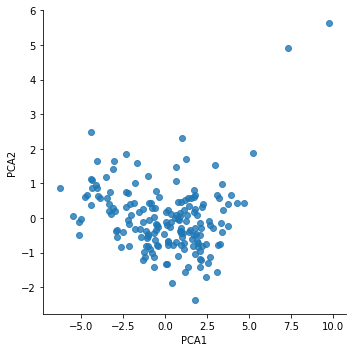

In [13]:
pca_scatter = sns.lmplot(x='PCA1',y='PCA2',data=x_df,fit_reg=False)

##### The PCA clustering is a bit fuzzy with about 2 clusters

### 3.2 Find k using SSE Elbow Method

In [14]:
from sklearn.cluster import KMeans

In [15]:
SSE = []
for i in range(2,12):
    kmeans = KMeans(n_clusters = i,random_state=10)
    kmeans.fit(x)
    SSE.append(kmeans.inertia_)

#### 3.2.1 Plot the elbow cure

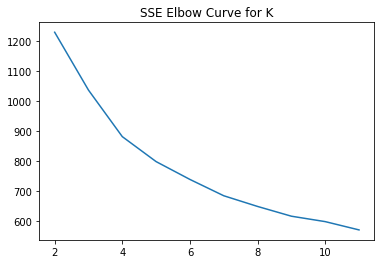

In [16]:
sns.lineplot(range(2,12),SSE)
plt.title('SSE Elbow Curve for K')
plt.show()

#### The Elbow curve seems to suggest 4 clusters.  

### 3.3 Use Silhouette Method to select k

In [17]:
from yellowbrick.cluster import KElbowVisualizer

In [18]:
#instantiate a scikit-learn K-Means model

model = KMeans(random_state = 0)
visualizer = KElbowVisualizer(model,k=(2,12),metric = 'silhouette',timings = False)

C:\Users\fobem\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\fobem\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\fobem\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


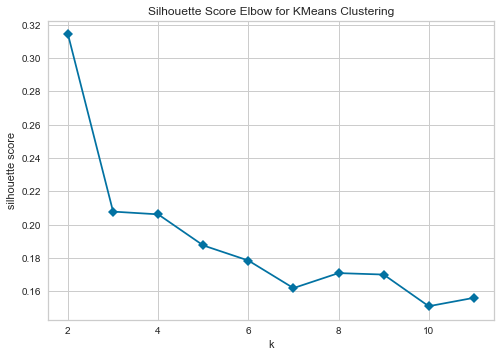

In [19]:
#Fit the data and visualize

visualizer.fit(x)
visualizer.poof()

### The silhouette method does not have a clear elbow, but k =  4 is suggested

## 4. Perform Kmeans and Meanshift Clustering using k = 4
On the basis of the Elbow method and Silhouette method, we adopt k = 4 as the clustering parameter

### 4.1 Kmeans Clustering using k = 4

In [20]:
kmeans4 = KMeans(n_clusters = 4, random_state = 10)
kmeans4.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)

In [21]:
kmeans4.labels_

array([0, 1, 0, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0,
       2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 0, 1,
       1, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2, 1, 1, 0, 0, 3,
       2, 1, 1, 1, 0, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 2, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0,
       0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0,
       3, 0, 0, 0])

In [22]:
cluster = pd.DataFrame(kmeans4.labels_)

In [23]:
x_df['Region'] = df_efi['Region']
x_df['Country'] = df_efi['Country']

In [24]:
x_df['cluster'] = cluster

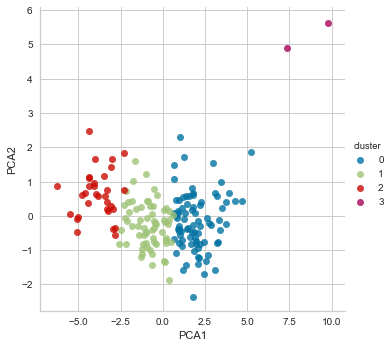

In [25]:
scatter = sns.lmplot(x = 'PCA1',y='PCA2',hue = 'cluster',data=x_df,fit_reg=False)

In [26]:
pd.crosstab(x_df.Region,x_df.cluster).reset_index()

cluster,Region,0,1,2,3
0,Americas,17,10,4,0
1,Asia-Pacific,21,11,7,1
2,Europe,5,26,13,1
3,Middle East and North Africa,7,6,1,0
4,Sub-Saharan Africa,30,11,4,0


#### 4.1.2 Conclusion from Kmeans clustering
The mean score of the Economic Freedom Index cast some doubts on the quality of the clustering. Americas, Asia-Pacific and Middle East/North Africa have almost similar mean score, while Africa has the least score with about 5 points behind.  Europe clealy has the highest point of 69.8 which is 8 points above the second ranked.  We'll go ahead and examine the Mean-Shift clustering to see whether kmeans results can be validated.

### 4.2 Mean-Shift Clustering

In [27]:
from sklearn import cluster
from sklearn.cluster import MeanShift

In [28]:
bandwidth = cluster.estimate_bandwidth(x,quantile = 0.2,n_samples = None)
ms = MeanShift(bandwidth = bandwidth,bin_seeding=True)
ms.fit(x)
labels = ms.labels_

In [29]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0], dtype=int64)

In [30]:
cluster2 = pd.DataFrame(labels)

In [31]:
x_df['cluster2']=cluster2

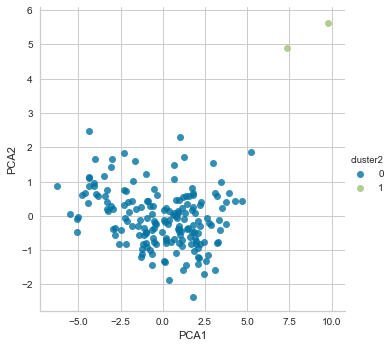

In [32]:
msplt = sns.lmplot(x='PCA1',y='PCA2',hue='cluster2',data=x_df,fit_reg=False)

#### 4.3 Results of Mean-Shift Clustering
Mean Shift clustering established only 2 as against the 4 clusters provided by kmeans clustering.  I guess Mean Shift obviously merged all other countries apart from sub-Saharan African countries into a cluster.

# 5. Evaluate the clusters (kmeans and Meanshift)

In [33]:
from sklearn import metrics

In [34]:
km_slht = metrics.silhouette_score(x,kmeans4.labels_)
km_slht

0.23044536368195784

In [35]:
ms_slht = metrics.silhouette_score(x,labels)
ms_slht

0.6191008639918715

## 5.1 The Silhouette Metrics 
The silhouette scocre meanshift clustering is 0.62 as against 0.23 for the kmeans.  It is very clear that the mean shift clustering was quite better in clustering the groups.

## 6.0 Analysis of Results and Conclustions
In this section, we compared the group mean of two features of Economic Freedom Indices with the mean GDP per capital to have a feel of the clustering.  We use the Kmeans and the Mean Shift clustering.

In [36]:
efx.head()

,Country,Region,World Rank,Region Rank,2020 Score,Prop_Rights,Jud_Effectiveness,Govt_Integrity,TaxBurden,GovtSpending,...,Country.1,pop,gdp,GDP Growth Rate (%),5 Year GDP Growth Rate (%),gdpPcp,Unemployment (%),Inflation,FDI,Public Debt
0,Afghanistan,Asia-Pacific,136.0,33.0,54.7,48.3,30.0,24.8,91.4,79.2,...,Afghanistan,36.020,72.648,2.300,2.2,2016.89,NaN,0.626,139.200000,7.079
1,Albania,Europe,57.0,30.0,66.9,57.1,33.0,38.8,85.9,74.6,...,Albania,2.874,38.356,4.162,3.1,13344.54,NaN,2.029,1293.617724,68.590
2,Algeria,Middle East and North Africa,169.0,14.0,46.9,37.9,35.0,28.3,75.4,52.6,...,Algeria,42.582,657.462,2.059,2.8,15439.92,NaN,4.270,1506.316886,36.872
3,Angola,Sub-Saharan Africa,154.0,35.0,52.2,36.9,14.3,15.1,87.3,85.7,...,Angola,29.250,199.319,-1.699,0.3,6814.33,NaN,19.629,-5732.491000,88.087
4,Argentina,Americas,149.0,26.0,53.1,50.5,47.0,49.7,69.6,50.7,...,Argentina,44.560,915.125,-2.515,-0.3,20537.06,NaN,34.277,12161.837000,86.289


In [37]:
X = df_efi.drop('Country',axis=1)

In [38]:
X.head()

,Region,Prop_Rights,Jud_Effectiveness,Govt_Integrity,FiscalHealth,Biz_free,Labour_free,Monetary_free,Trade_free,Investment_free,Financial_free,gdpPcp
0,Asia-Pacific,48.3,30.0,24.8,99.9,54.7,61.6,81.0,66.0,10.0,10.0,2016.89
1,Europe,57.1,33.0,38.8,86.3,65.7,52.1,81.2,88.4,70.0,70.0,13344.54
2,Middle East and North Africa,37.9,35.0,28.3,17.3,63.0,50.5,76.2,66.2,30.0,30.0,15439.92
3,Sub-Saharan Africa,36.9,14.3,15.1,71.9,57.7,61.1,59.6,66.2,30.0,40.0,6814.33
4,Americas,50.5,47.0,49.7,24.7,60.2,46.5,53.7,69.2,55.0,60.0,20537.06


In [39]:
X['cluster1']=x_df['cluster']

In [40]:
X['cluster2']=x_df['cluster2']

## 6.0 Analysis of Results:  Kmeans and MeanShift

### 6.1 Kmeans clustering analysis
Kmeans grouped the countries into 4 clusters. In cluster 0, countries with lowest mean score in government integrity (37.02) had the least per capital GDP of ($16,647) while countries with an average score of (59.06) had the highest average per capital GDP of ($32,761) which is twice that of those in the first group i.e. cluster 0.  

In terms of property rights' protection, countries in cluster 3.0 recoreded the highest mean score of 70.0, however, their mean per capital GDP was lower by $10,000 compared with those in cluster 2.0 with only 4 points difference in property rights protection.

In [41]:
kmgroup = X.groupby('cluster1')['Prop_Rights','Govt_Integrity','gdpPcp'].mean()
kmgroup

,Prop_Rights,Govt_Integrity,gdpPcp
cluster1,,,
0.0,51.092500,37.022500,16646.853025
1.0,62.253125,48.065625,24129.165781
2.0,65.365517,59.062069,32760.857931
3.0,69.850000,57.100000,23895.095000


### 6.2 Mean Shift Cluster
The Mean Shift clustering which was adjudged to be better than kmeans in this analysis classified the countries into 2.  Those in cluster 0.0 had an average score of 44.80 in government integrity which was more than 10 points lower than those in group 1.0.  However, the difference in income was a little over $1000.  Similar difference was observed in property rights and GDP differentials.

In [42]:
msgroup = X.groupby('cluster2')['Prop_Rights','Govt_Integrity','gdpPcp'].mean()
msgroup

,Prop_Rights,Govt_Integrity,gdpPcp
cluster2,,,
0.0,57.613873,44.802312,22116.067815
1.0,69.850000,57.100000,23895.095000
